# Deep RL

Name: Abolfazl Eshagh

Student ID: 99101105

## Environment
Our environemnt is for painting a grayscale image with circles. Our final goal is to paint the image with the least number of circles. The environment is defined as follows:

In [ ]:
#some parts of this code is prepared with some help from github copilot
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np


class Environment:
    def __init__(self, base: str):
        """
        initializes the environemnt.

        Args:
            base: base image local address
        """
        img = Image.open(base)
        gray_img = img.convert("L")
        self.base_image = gray_img
        self.base_np = np.array(gray_img, dtype=int)
        self.width = img.size[0]
        self.height = img.size[1]
        self.reset()

    def reset(self):
        """
        resets the drawing canvas.
        """
        self.new_image = Image.new('L', size=(
            self.width, self.height), color=0)
        self.canvas = ImageDraw.Draw(self.new_image)
        self.new_np = np.array(self.new_image, dtype=int)
        self.last_loss = self.loss()

    def draw(self, X, Y, R, alpha):
        """
        draws a circle on the drawing canvas.

        Args:
            X: X param of circle center. 0 < X < width
            Y: Y param of circle center. 0 < Y < height
            R: radius of circle. 1 < R < min(width, height) // 2
            alpha: color of the drawn circle. 0 < alpha < 255
        
        Returns:
            reward of the drawn circle on canvas based on loss difference before and after
        """
        self.canvas.ellipse((X - R, Y - R, X + R, Y + R), fill=alpha)
        self.new_np = np.array(self.new_image, dtype=int)
        new_loss = self.loss()
        delta_loss = self.last_loss - new_loss
        self.last_loss = new_loss
        return delta_loss

    def loss(self):
        """
        loss function of drawn canvas comapred to target image

        Returns:
            MSE loss
        """
        return np.mean(np.power(self.delta_image(), 2))

    def delta_image(self):
        """
        difference of drawn canvas and the target image

        Returns:
            difference as a np array
        """
        return self.base_np - self.new_np

    def imshow(self):
        """
        shows the drawn canvas

        Returns:
            drawn canvas plot
        """
        plt.imshow(self.new_image, cmap='gray')

    def baseshow(self):
        """
        shows the target image

        Returns:
            target image plot
        """
        plt.imshow(self.base_image, cmap='gray')

    def deltashow(self):
        """
        shows the difference canvas based on difference of target image and drawn canvas.
        white areas shows where target was white and canvas was black.
        black areas shows where targe was black and canvas was white.
        gray areas shows where colors matched.

        Returns:
            difference canvas plot
        """
        plt.imshow((self.delta_image() + 256) / 2, cmap='gray')


Base Image:


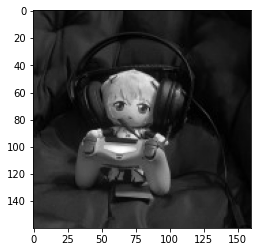

Current Canvas:


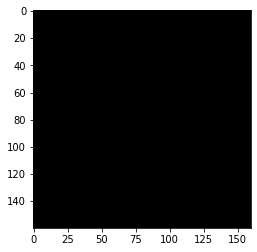

Difference Canvas:


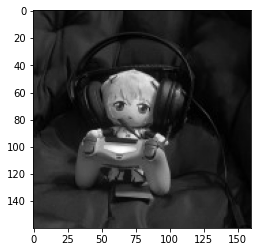

Drawn Circle Reward: 773.455
Current Canvas:


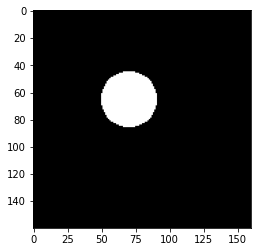

Difference Canvas:


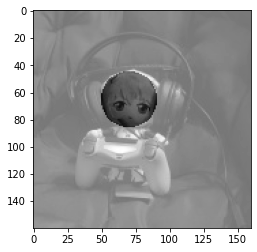

Drawn Circle Reward: 87.922
Current Canvas:


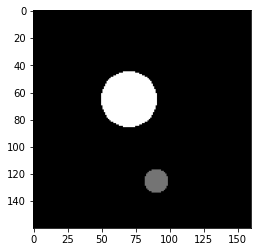

Difference Canvas:


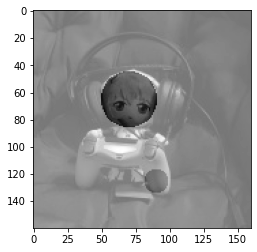

Drawn Circle Reward: 30.750
Current Canvas:


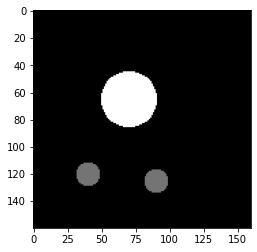

Difference Canvas:


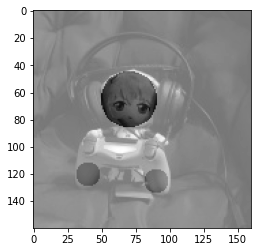

Drawn Circle Reward: -423.534
Current Canvas:


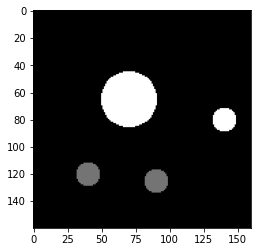

Difference Canvas:


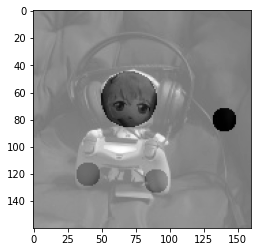

In [ ]:
env = Environment('imtest.jpg')
print('Base Image:')
env.baseshow()
plt.show()
print('Current Canvas:')
env.imshow()
plt.show()
print('Difference Canvas:')
env.deltashow()
plt.show()
print(f'Drawn Circle Reward: {env.draw(70, 65, 20, 220):.3f}')
print('Current Canvas:')
env.imshow()
plt.show()
print('Difference Canvas:')
env.deltashow()
plt.show()
print(f'Drawn Circle Reward: {env.draw(90, 125, 8, 100):.3f}')
print('Current Canvas:')
env.imshow()
plt.show()
print('Difference Canvas:')
env.deltashow()
plt.show()
print(f'Drawn Circle Reward: {env.draw(40, 120, 8, 100):.3f}')
print('Current Canvas:')
env.imshow()
plt.show()
print('Difference Canvas:')
env.deltashow()
plt.show()
print(f'Drawn Circle Reward: {env.draw(140, 80, 8, 220):.3f}')
print('Current Canvas:')
env.imshow()
plt.show()
print('Difference Canvas:')
env.deltashow()
plt.show()

## Neural Network
Design an architecture for your neural network to predict actions based on difference canvas. You can read `Agent` class to understand how online and target models work.

Using a convolutional architecture is recommended. 

In [ ]:
import torch
from torch import nn
from torch.functional import F
import torchvision
import copy

class AgentNet(nn.Module):
    def __init__(self, width, height):
        super().__init__()
        # TODO: define your model here
        self.online = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * width * height, 256),
            nn.ReLU(),
            nn.Linear(256, 4)
        )

        self.target = copy.deepcopy(self.online)
        for p in self.target.parameters():
            p.requires_grad = False

    def forward(self, input, model):
        if model == 'online':
            return self.online(input)
        elif model == 'target':
            return self.target(input)


## Agent
This is the recommended agent structure for this environment. You can change it as you please.

You must save your model after training. your model should be saved as `model.pkl` in the same directory as this notebook.

In [ ]:
import torch
import random
from collections import deque


class Agent:
    def __init__(self, width, height):
        """
        initializes the agent.

        Args:
            width: base image width
            height: base image height
        """
        self.width = width
        self.height = height
        self.memory = deque(maxlen=20000) # cache size limited by GPU memory
        self.batch_size = 32 # training batch size

        self.exploration_rate = 1 # initial epsilon
        self.exploration_rate_decay = 0.9999975 # epsilon decay rate
        self.exploration_rate_min = 0.1 # minimum epsilon
        self.gamma = 0.9 # reward gamma

        self.curr_step = 0 # initial step
        self.burnin = 5e3 # initial step before training begins
        self.learn_every = 3 # trains every K step
        self.sync_every = 1e3 # sync online and target model every K step
        self.save_every = 2.5e4 # saves model every K step

        self.use_cuda = torch.cuda.is_available()

        self.net = AgentNet(width, height).float()
        if self.use_cuda:
            self.net = self.net.to(device='cuda')

        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.00025)
        self.loss_fn = torch.nn.SmoothL1Loss()

    def act(self, state):
        """
        predicts agent action by epsilon-greedy policy

        Args:
            state: difference canvas
        
        Returns:
            agent predicted action
        """
        if np.random.rand() < self.exploration_rate:
            X = np.random.randint(self.width)
            Y = np.random.randint(self.height)
            R = np.random.randint(1, min(self.width, self.height)//2)
            alpha = np.random.randint(255)
        else:
            state = torch.FloatTensor(state)
            if self.use_cuda:
                state = state.cuda()
            state = state.unsqueeze(0)
            # TODO: predict action with your model here
            action = self.net(state, 'online')
            X, Y, R, alpha = action[0].detach().cpu().numpy()
            X = int(X)
            Y = int(Y)
            R = int(R)
            alpha = int(alpha)
            # self.exploration_rate *= self.exploration_rate_decay
            # self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)
            # self.curr_step += 1
        return X, Y, R, alpha
        # self.exploration_rate *= self.exploration_rate_decay
        # self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)
        # self.curr_step += 1
        # return X, Y, R, alpha

    def cache(self, state, next_state, reward, action):
        """
        caches state and action info for training

        Args:
            state: drawing canvas
            next_state: drawing canvas after action
            reward: reward for the drawn circle
            action: tuple of X, Y, R, alpha
        """
        state = torch.FloatTensor(state)
        next_state = torch.FloatTensor(next_state)
        reward = torch.FloatTensor([reward])
        action = torch.LongTensor([action])
        if self.use_cuda:
            state = state.cuda()
            next_state = next_state.cuda()
            reward = reward.cuda()
            action = action.cuda()
        self.memory.append((state, next_state, reward, action))

    def recall(self):
        """
        recalls cached state and action info for training

        Returns:
            state: drawing canvas
            next_state: drawing canvas after action
            reward: reward for the drawn circle
            action: tuple of X, Y, R, alpha
        """
        batch = random.sample(self.memory, self.batch_size)
        state, next_state, reward, action = map(torch.stack, zip(*batch))
        return state, next_state, reward.squeeze(), action.squeeze()

    def td_estimate(self, state, next_state, action):
        """
        returns online critic value for the state given action or Q(s, a)

        Args:
            state: drawing canvas
            next_state: drawing canvas after action
            action: tuple of X, Y, R, alpha
        
        Returns:
            critic value with online model
        """
        # TODO: get critic value from online model
        # return self.net(state, 'online').gather(1, action.unsqueeze(1)).squeeze()
        return self.net(state, 'online')[action]


    @torch.no_grad()
    def td_target(self, state, next_state, action, reward):
        """
        returns taget critic value for the next state or max Q(s', a')

        Args:
            state: drawing canvas
            next_state: drawing canvas after action
            action: tuple of X, Y, R, alpha
            reward: reward for the drawn circle
        
        Returns:
            critic value with target model
        """
        next_Q = self.net(next_state, 'target').max(1)[0]

        return (reward + self.gamma * next_Q).float()

    def update_Q_online(self, td_estimate, td_target):
        """
        updates online model

        Args:
            td_estimate: online critic value for the state
            td_target: target critic value for the next state
        
        Returns:
            loss of estimate vs target
        """
        loss = self.loss_fn(td_estimate, td_target.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def sync_Q_target(self):
        """
        sync online and target model
        """
        self.net.target.load_state_dict(self.net.online.state_dict())

    def learn(self):
        """
        recalls random samples and trains online model with the rewards.
        """
        #in this function we are going to train the model
        # Sample batch from memory
        if len(self.memory) < self.batch_size:
            return
        state, next_state, reward, action = self.recall()
        td_estimate = self.td_estimate(state, next_state, action)
        td_target = self.td_target(state, next_state, action, reward)
        loss = self.update_Q_online(td_estimate, td_target)
        return loss
        # if self.curr_step % self.sync_every == 0:
        #     self.sync_Q_target()
        # if self.curr_step % self.save_every == 0:
        #     torch.save(self.net.state_dict(), 'model.pkl')
        # if self.curr_step < self.burnin:
        #     return None, None
        # if self.curr_step % self.learn_every != 0:
        #     return None, None
        # state, next_state, reward, action = self.recall()
        # td_est = self.td_estimate(state, next_state, action)
        # td_tgt = self.td_target(state, next_state, action, reward)
        # loss = self.update_Q_online(td_est, td_tgt)

## Train

Difference canvas is used as input to the model to decide the next action. The agent should learn to paint the image with the least number of circles.

In [ ]:
torch.cuda.empty_cache()
from tqdm import tqdm

episodes = 1000
moves = 1000
print(f'Base Loss: {env.loss():.3f}')
agent = Agent(env.width, env.height)
losses = []
pbar = tqdm(range(episodes))
for e in pbar:
    torch.cuda.empty_cache() #if you run into CUDA_OUT_OF_MEMORY
    state = env.reset()
    for m in range(1, moves+1):
        curr_state = env.delta_image().reshape(1, env.width, env.height)
        action = agent.act(curr_state)
        reward = env.draw(*action)
        next_state = env.delta_image().reshape(1, env.width, env.height)
        agent.cache(curr_state, next_state, reward, action)
        agent.learn()
    pbar.set_description(f'Loss {env.loss():.3f}')
    losses.append(env.loss())
    if e % 10 == 0:
        env.imshow()
        plt.show()

RuntimeError: ignored

## Test and Visualize

First visualize the loss in the training process. Then load your saved model and test it on the environment.

You must submit your trained model with your notebook which is saved as `model.pkl`. if your model is large, you can upload it to Google Drive and share it with me.

In [ ]:
plt.title('Loss')
plt.plot(losses)
plt.show()

In [ ]:
state = env.reset()
# agent.net.model.load_state_dict(torch.load('model.pkl')) if you want to load the saved model
agent.net.eval()
for m in range(1, moves+1):
    curr_state = env.delta_image().reshape(1, env.width, env.height)
    agent.exploration_rate = 0
    action = agent.act(curr_state)
    reward = env.draw(*action)
    next_state = env.delta_image().reshape(1, env.width, env.height)
print(f'Final Loss: {env.loss()}')
print('Drawn Canvas:')
env.imshow()
plt.show()
print('Target Image:')
env.baseshow()
plt.show()
print('Difference Canvas:')
env.deltashow()
plt.show()


## Useful Links
[Learning to Paint With Model-based Deep Reinforcement Learning](https://arxiv.org/abs/1903.04411)

[Understanding Actor Critic Methods and A2C](https://towardsdatascience.com/understanding-actor-critic-methods-931b97b6df3f)

[RL introduction: simple actor-critic for continuous actions](https://medium.com/@asteinbach/rl-introduction-simple-actor-critic-for-continuous-actions-4e22afb712)